In [1]:
import torch
import numpy as np
import networkx as nx
from random import random


/Users/jason/miniconda3/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


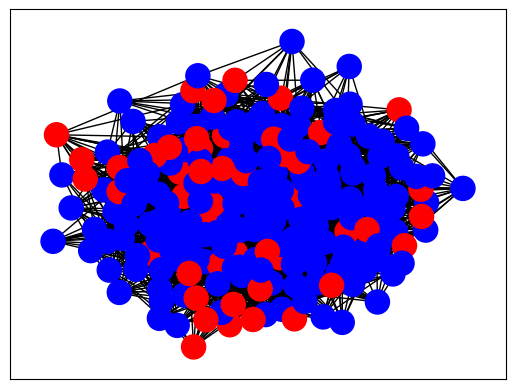

In [146]:
# Input variables. Feel free to adjust these and see the results
recovery_prob = .5
infection_prob = .2
remove_prob = .2
N = 220
L = N//10
pi = .2
num_infected = 0

# Generating the graph.
def gen_graph(pi):
    global num_infected
    features = np.random.choice([0, 1], size=N, p=[1-pi, pi])
    if 1 not in features:
        features[0] = 1
    num_infected = len([f for f in features if f==1])
    g = nx.erdos_renyi_graph(N,L/N)

    for node in g.nodes():
        g.nodes[node]['f'] = features[node]
    return g

g = gen_graph(pi)
# Plot the graph. Red=infected, Blue=uninfected(healthy).
node_colors = ['r' if g.nodes[node]['f'] == 1 else 'b' for node in g.nodes()]
pos = nx.spring_layout(g)
nx.draw_networkx(g,pos,node_color=node_colors,with_labels=False)


 


In [3]:
def time_step(g):
    '''
    time_step applies all three events for a given step in time in the graph
    '''
    g = recover(g)
    g = infect(g)
    g = reconnect(g)
    return g

def recover(g):
    '''
    recover takes the graph and applies the chance of 
    recovery to each infected node.
    '''
    for node in g.nodes():
        if g.nodes[node]['f'] == 1 and random() <= recovery_prob:
            g.nodes[node]['f'] = 0
            global num_infected
            num_infected -= 1
    return g

def infect(g):
    '''
    infect takes the graph and applies the chance of 
    infected to each healthy node for each connection
    to an infected node.
    '''
    out = g.copy()
    for node in g.nodes():
        if g.nodes[node]['f'] == 0:
            for _,neighbor in g.edges(node):
                if g.nodes[neighbor]['f'] == 1 and random() < infection_prob:
                    out.nodes[node]['f'] = 1
                    global num_infected
                    num_infected += 1
    return out

def reconnect(g):
    '''
    reconnect takes the graph and, for each healthy node,
    calculates the chance to reconnect from an infected neighbor
    to another healthy node. It does this for each connection to 
    an infected node.
    '''
    out = g.copy()
    w = remove_prob * num_infected/N
    for node in g.nodes():
        if g.nodes[node]['f'] == 0:
            for _,neighbor in g.edges(node):
                if g.nodes[neighbor]['f'] == 1 and random() < w:
                    out.remove_edge(node,neighbor)
                    new_neighbor = get_neighbor(g,node)
                    # If no other nodes are uninfected, just disconnect with no new connection
                    if new_neighbor:
                        out.add_edge(node,get_neighbor(g,node))
    return out

def get_neighbor(g,node):
    '''
    Returns a node in the graph g that is uninfected and not already a
    neighbor to the given node.
    '''
    for n in g.nodes():
        if g.nodes[n]['f'] == 0:
            if n != node and (node, n) not in g.edges(node):
                return n
    
    

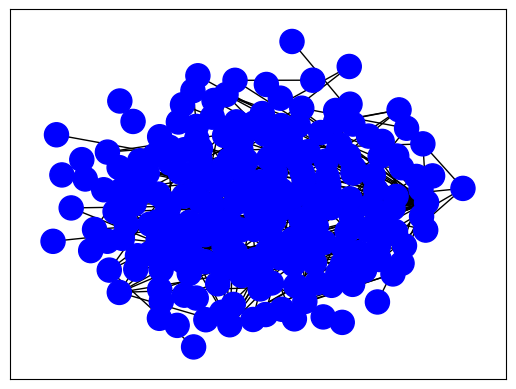

In [168]:
# Plot the graph after one step in time
g = time_step(g)
node_colors = ['r' if g.nodes[node]['f'] == 1 else 'b' for node in g.nodes()]
nx.draw_networkx(g,pos,node_color=node_colors,with_labels=False)